# "Func-tastic Python: Mastering Functools"

There's your life as Python user before you knew about functools and then there's your life as a Python user after. The same can be said about itertools & collections, but that's a story for another time. People even go as far as saying that functools is [life-changing](https://www.reddit.com/r/Python/comments/qacvb4/functools_changed_my_life/). Seeing that I'm writing this post, it'll be no surprise that I agree.

Functools is part of the python standard library. The functools [documentation](https://docs.python.org/3/library/functools.html) itself is quite nice, but I thought I'd try presenting my own take on it. There is quite a bit to explore within functools:

<center><img src="./functools2.png" alt="Functools utils" width="70%"></center>

## Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import time
from sklearn.datasets import load_breast_cancer
import sqlite3
import random
from typing import List, Dict
import math
from tqdm import tqdm

In [2]:
from functools import partial, reduce, cache, lru_cache, cached_property, singledispatch, partialmethod, total_ordering, wraps

## Partials:

Partials help us create a new function by partially defining some of the arguments of an existing function. Partials allow freezing of some function arguments, allowing us to create specialized versions of those functions. We can also use it to reduce the number of arguments a function takes. Let's look at a couple of examples: 

Text(0, 0.5, 'log')

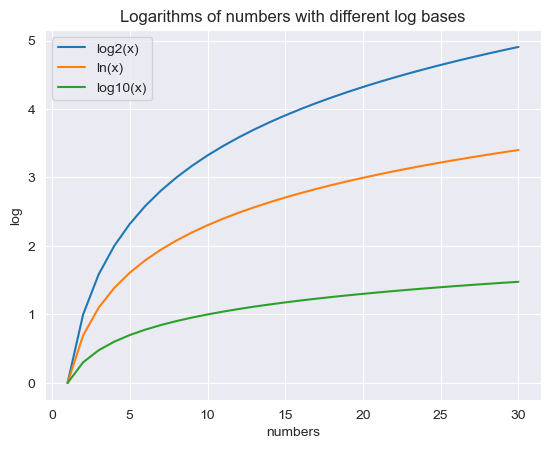

In [3]:
def take_logarithm(number, base):
    return math.log(number, base)

log_2 = partial(take_logarithm, base=2)
log_e = partial(take_logarithm, base=math.e)
log_10 = partial(take_logarithm, base=10)
results_log2 = [log_2(i) for i in range(1, 31)]
results_loge = [log_e(i) for i in range(1, 31)]
results_log10 = [log_10(i) for i in range(1, 31)]

x = list(range(1,31))
plt.plot(x, results_log2, label="log2(x)")
plt.plot(x, results_loge, label="ln(x)")
plt.plot(x, results_log10, label="log10(x)")
plt.legend()
plt.title("Logarithms of numbers with different log bases")
plt.xlabel("numbers")
plt.ylabel("log")

In case we want to use partials within a class, we would use `partialmethod`:

In [4]:
class PokemonNormalType:
    def __init__(self):
        self._conscious = True
    @property
    def conscious(self):
        return self._conscious
    def set_consciousness(self, state):
        self._conscious = bool(state)
    knockout = partialmethod(set_consciousness, False)
    heal = partialmethod(set_consciousness, True)

In [5]:
pokemon = PokemonNormalType()
print(pokemon.conscious)  
pokemon.knockout()
print(pokemon.conscious)  
pokemon.heal()
print(pokemon.conscious)  

True
False
True


If you feel like you need a refresher on classes and OOPs, head on [here](https://kaushikmoudgalya.medium.com/oops-for-data-scientists-7294617d2d44).

## Single Dispatch:

The `@singledispatch` decorator transforms a function into a generic function, i.e. it helps overload functions. Say that we need to handle different input types differently. Handling these input types with if-else would be quite cumbersome. This is where `@singledispatch` comes in. This decorator helps us avoid long conditionals full of type checking code. It's also easier to maintain and add support for new types using single dispatch when compared to if-else conditionals. Let's compare the two methods:

### Handling different input types with conditionals

In [6]:
def punditional(input):
    if isinstance(input, int): # well at least we're doing better than type(input) == int (╹◡◠)
        print(f"Number, number on the wall, who is the primest of them all? Perhaps {input}?")
    elif isinstance(input, float):
        print(f"{input} like a butterfly, sting like a bee.")
    elif isinstance(input, str):
        print(f"This {input} string really ties things up nicely.")
    elif isinstance(input, list):
        print(f"Let's list out all the ways to have pun: {input}")
    else:
        raise NotImplementedError(f"Cannot process type {type(input)}")

In [7]:
punditional(10)
punditional(23.0)
punditional("old")
punditional(["singing", "dancing", "driving?"])

Number, number on the wall, who is the primest of them all? Perhaps 10?
23.0 like a butterfly, sting like a bee.
This old string really ties things up nicely.
Let's list out all the ways to have pun: ['singing', 'dancing', 'driving?']


### Handling different input types with `@singledispatch`

In [8]:
@singledispatch
def pun_dispatch(input):
    raise NotImplementedError(f"Cannot process type {type(input)}")

@pun_dispatch.register
def _(input: int):
    print(f"Number, number on the wall, who is the primest of them all? Perhaps {input}?")

@pun_dispatch.register
def _(input: float):
    print(f"{input} like a butterfly, sting like a bee.")

@pun_dispatch.register
def _(input: str):
    print(f"This {input} string really ties things up nicely.")

@pun_dispatch.register
def list_handler(input: list):
    print(f"Let's list out all the ways to have pun: {input}")

@pun_dispatch.register
def dict_handler(input: dict):
    print(f"I'm a-dict-ed to puns pairs: {list(input.keys())} & {list(input.values())}")

In [9]:
pun_dispatch(10)
pun_dispatch(23.0)
pun_dispatch("old")
pun_dispatch(["singing", "dancing", "driving?"])
pun_dispatch({"12": "chachacha", "34":"blahblahblah"})

Number, number on the wall, who is the primest of them all? Perhaps 10?
23.0 like a butterfly, sting like a bee.
This old string really ties things up nicely.
Let's list out all the ways to have pun: ['singing', 'dancing', 'driving?']
I'm a-dict-ed to puns pairs: ['12', '34'] & ['chachacha', 'blahblahblah']


While overloading the function, you can name the overloaded functions as you like, you aren't forced to use "_" as demonstrated by the functions named `list_handler()` and `dict_handler()`. You can look at all the type handling that you've defined under the registry property of the function. You'll notice the difference between using `_` as a stand-in and using non `_` function names:

In [10]:
pun_dispatch.registry # this is dictionary of types mapped to implementations

mappingproxy({object: <function __main__.pun_dispatch(input)>,
              int: <function __main__._(input: int)>,
              float: <function __main__._(input: float)>,
              str: <function __main__._(input: str)>,
              list: <function __main__.list_handler(input: list)>,
              dict: <function __main__.dict_handler(input: dict)>})

You can check which implementation will be used for a specific input type using dispatch:

In [11]:
pun_dispatch.dispatch(int)

<function __main__._(input: int)>

In [12]:
pun_dispatch.dispatch(complex) # this is the default implementation, check the registry output above

<function __main__.pun_dispatch(input)>

The single dispatch version is more readable, modular and maintainable. If you're thinking that conditionals allow you check multiple types at once, you can do that with `@singledispatch` too:

In [13]:
@singledispatch
def pun_dispatch(input):
    raise NotImplementedError(f"Cannot process type {type(input)}")

@pun_dispatch.register(int)
@pun_dispatch.register(float)
def _(input):
    print(f"All numbers are NOT equal to {input}, but some are more NOT equal to {input} than others.")

In [14]:
pun_dispatch(27)
pun_dispatch(49.0)

All numbers are NOT equal to 27, but some are more NOT equal to 27 than others.
All numbers are NOT equal to 49.0, but some are more NOT equal to 49.0 than others.


`@singledispatch` is quite flexible, you can use type Unions as well as imported types from other libraries:

In [15]:
from collections.abc import MutableSequence
from typing import Union

@singledispatch
def pun_dispatch(input):
    raise NotImplementedError(f"Cannot process type {type(input)}")

@pun_dispatch.register
def _(input: MutableSequence):
    print(f"Out of line: {input}")

@pun_dispatch.register
def _(input: int | float):
    print("Am I prime or am I a butterfly or best of all, a prime butterfly?")

@pun_dispatch.register
def _(input: Union[dict, set]):
    print("The dicts and sets of this world have hereby unionized. They demand higher wages.")

In [16]:
pun_dispatch(13)
pun_dispatch(99.0)
pun_dispatch(list(range(5)))
pun_dispatch({1: "hello", 2: "hi"})
pun_dispatch({1, 2, 4, 8, "accelerate"})

Am I prime or am I a butterfly or best of all, a prime butterfly?
Am I prime or am I a butterfly or best of all, a prime butterfly?
Out of line: [0, 1, 2, 3, 4]
The dicts and sets of this world have hereby unionized. They demand higher wages.
The dicts and sets of this world have hereby unionized. They demand higher wages.


For generic class methods, use the `@singledispatchmethod` decorator rather than the `@singledispatch` decorator.

## Reduce:

I promise to *try* to restrict my verbose of the subject material ;). It's easier to understand reduce through examples anyway:

In [17]:
numbers = list(range(1,21))
random.shuffle(numbers)
print(numbers)

[1, 16, 4, 11, 19, 17, 5, 8, 2, 18, 14, 6, 15, 10, 13, 7, 9, 12, 3, 20]


In [18]:
summation = reduce(lambda x, y: x+y, numbers)
print(f"{summation=} & {sum(numbers)=}")
product = reduce(lambda x,y: x*y, numbers)
print(f"{product=} & 20!=2432902008176640000")
concatenated = reduce(lambda x,y: str(x) + " " + str(y), numbers)
print(concatenated) 
maximum = reduce(lambda x, y: x if x>y else y, numbers)
print(maximum)

summation=210 & sum(numbers)=210
product=2432902008176640000 & 20!=2432902008176640000
1 16 4 11 19 17 5 8 2 18 14 6 15 10 13 7 9 12 3 20
20


Essentially, the reduce function will keep applying a function to an iterable until there aren't any more elements of the iterator to apply the function on. The reduce function can take 3 arguments:

`reduce( function_to_apply, iterable, initial )`

For instance, I could seed the previous summation to start at 1000:

In [19]:
reduce(lambda x, y: x+y, numbers, 1000)

1210

Even though we say "function_to_apply" it could also be a class method / class instantiation. Anything that takes in 2 inputs and gives one output. I can never hope to explain the reduce function as well as it has been explained on [RealPython](https://realpython.com/python-reduce-function/). Thought we'll still look at one more slightly more data-sciencey example:

In [20]:
transport = ["walk", "cycle", "car", "bus", "train", "plane"]
weights = [5, 10, 20, 30, 40, 50]  # these are toy weights
heights = [5, 5, 10, 15, 15, 20]   # these are toy heights
eco_friendly = [True, True, False, True, True, False]

weights_df = pd.DataFrame({'transport': transport, 'weights': weights})
heights_df = pd.DataFrame({'transport': transport, 'heights': heights})
eco_friendly_df = pd.DataFrame({'transport': transport, 'eco_friendliness': eco_friendly})
df_list = [weights_df, heights_df, eco_friendly_df]

In [21]:
weights_df

,transport,weights
0,walk,5
1,cycle,10
2,car,20
3,bus,30
4,train,40
5,plane,50


In [22]:
heights_df

,transport,heights
0,walk,5
1,cycle,5
2,car,10
3,bus,15
4,train,15
5,plane,20


In [23]:
merged_df = reduce(lambda x,y: x.merge(y, on='transport'), df_list)

In [24]:
merged_df

,transport,weights,heights,eco_friendliness
0,walk,5,5,True
1,cycle,10,5,True
2,car,20,10,False
3,bus,30,15,True
4,train,40,15,True
5,plane,50,20,False


## Total Ordering:

If a class defines the `__eq__()` comparison method along with one of the less than (`__lt__()`) / less than or equal to (`__gt__()`) / greater than or equal (`__ge__()`), total ordering will take care of defining the rest.

In [25]:
@total_ordering
class PokemonStats:
    def __init__(self, name):
        self.name = name
        self.attack = random.randint(0, 100)
        self.special_attack = random.randint(0, 100)
        self.defense = random.randint(0, 100)
        self.special_defense = random.randint(0, 100)
        self.hp = 100
        self.shiny = random.choices([True, False], weights=[0.0001, 0.9999], k=1)[0]

    def compare(self, other):
        if not isinstance(other, PokemonStats):
            raise ValueError("Can only compare with another Pokemon object")
        
        result = []
        result.append(f"Comparing {self.name} and {other.name}:\n")
        result.append(f"{'Attribute':<15} {'Pokemon 1':<15} {'|':<5} {'Pokemon 2':<15}")
        result.append(f"{'-'*15} {'-'*15} {'|':<5} {'-'*15}")
        for (a1, v1), (a2, v2) in zip(vars(self).items(), vars(other).items()):
            result.append(f"{a1.capitalize():<15} {str(v1):<15} {'|':<5} {str(v2):<15}")
        return "\n".join(result)
    
    def get_total(self):
        stats = 0
        for attribute, value in vars(self).items():
            if attribute != "name" and attribute != "shiny":
                stats += value
        stats += 25 if self.shiny else 0  
        return stats
    
    def __eq__(self, other):
        if not isinstance(other, PokemonStats):
            return NotImplemented
        return self.get_total() == other.get_total()

    def __lt__(self, other):
        if not isinstance(other, PokemonStats):
            return NotImplemented
        return self.get_total() < other.get_total()

In [26]:
ratata_stats, eevee_stats = PokemonStats("Ratata"), PokemonStats("Eevee")
print(ratata_stats.compare(eevee_stats))

Comparing Ratata and Eevee:

Attribute       Pokemon 1       |     Pokemon 2      
--------------- --------------- |     ---------------
Name            Ratata          |     Eevee          
Attack          47              |     65             
Special_attack  59              |     38             
Defense         69              |     47             
Special_defense 28              |     6              
Hp              100             |     100            
Shiny           False           |     False          


In [27]:
print(f"{ratata_stats.name}'s total:{ratata_stats.get_total()}, {eevee_stats.name}'s total: {eevee_stats.get_total()}")
print(f"Is {ratata_stats.name}'s total the same as {eevee_stats.name}'s total? {ratata_stats == eevee_stats}")
print(f"Is {ratata_stats.name}'s total less than {eevee_stats.name}'s total? {ratata_stats < eevee_stats}")
print(f"Is {ratata_stats.name}'s total less than or equal to {eevee_stats.name}'s total? {ratata_stats <= eevee_stats}")
print(f"Is {ratata_stats.name}'s total greater than {eevee_stats.name}'s total? {ratata_stats > eevee_stats}")
print(f"Is {ratata_stats.name}'s total greater than or equal to {eevee_stats.name}'s total? {ratata_stats >= eevee_stats}")

Ratata's total:303, Eevee's total: 256
Is Ratata's total the same as Eevee's total? False
Is Ratata's total less than Eevee's total? False
Is Ratata's total less than or equal to Eevee's total? False
Is Ratata's total greater than Eevee's total? True
Is Ratata's total greater than or equal to Eevee's total? True


Despite us only defining `__eq__()` and `__lt__()`, we are able to use the other comparison methods such as greater than and greater than equal to, etc. thanks to `@total_ordering`.

## Wraps:

Let's start with a function:

In [28]:
def hello():
    """Come say hello, we don't bite ;)"""
    print("I promise that we're all bark")

hello()
print("-"*60)
print(hello.__name__)
print(hello.__doc__)

I promise that we're all bark
------------------------------------------------------------
hello
Come say hello, we don't bite ;)


That works as expected. What if we do this:

In [29]:
def plush_decor(func):
    def wrapper(*args, **kwargs):
        print("Let's add some pizzazz to this function!")
        return func(*args, **kwargs)
    return wrapper


@plush_decor
def hello():
    """Come say hello, we don't bite ;)"""
    print("I promise that we're all bark")

hello()
print("-"*60)
print(hello.__name__)
print(hello.__doc__)

Let's add some pizzazz to this function!
I promise that we're all bark
------------------------------------------------------------
wrapper
None


When we use the decorator as shown, the `hello` function is called from within the wrapper function as evidenced by the output printed. Instead of printing the `hello`'s name and docs, we end up printing the wrapper function's name and docs. To fix this, we can use the `@wraps` decorator:

In [30]:
def plush_decor(func):
    @wraps(func) # look here
    def wrapper(*args, **kwargs):
        print("Let's add some pizzazz to this function!")
        return func(*args, **kwargs)
        print("Thanks for coming to my TED talk.")
    return wrapper

@plush_decor
def hello():
    """Come say hello, we don't bite ;)"""
    print("I promise that we're all bark")

hello()
print("-"*60)
print(hello.__name__)
print(hello.__doc__)

Let's add some pizzazz to this function!
I promise that we're all bark
------------------------------------------------------------
hello
Come say hello, we don't bite ;)


This is handy tip to keep in mind when writing your own decorators. It might also help you maintain your sanity if you do any debugging using `help(function_name)` which prints the docstring of the function.

In [31]:
help(hello)

Help on function hello in module __main__:

hello()
    Come say hello, we don't bite ;)



## Caching:

This might arguably be the most useful gift given by functools magi.  
Say we're writing a simple program to compute fibonacci numbers: 0, 1, 1, 2, 3, 5, etc; I consider 0 to be term number 1 and not term number 0 (I like the inputs to be integers greater than zero).

In [32]:
def fibonacci_basic(n):
    "Compute nth fibonacci number"
    assert n >= 1, "Enter an integer greater than 0."
    if n == 1:
        return 0
    if n == 2:
        return 1
    else:
        return fibonacci_basic(n-1) + fibonacci_basic(n-2)

This is a straightforward recursive program to compute fibonacci numbers. It is quite inefficient. Let's try to compute the first 40 fibonacci numbers along with the time taken to compute them.

In [33]:
%%time
fibonacci_nums = [fibonacci_basic(i) for i in range(1,41)]

CPU times: total: 1min
Wall time: 1min 12s


In [34]:
print(fibonacci_nums)

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 514229, 832040, 1346269, 2178309, 3524578, 5702887, 9227465, 14930352, 24157817, 39088169, 63245986]


I'll be focusing on wall time, since that is what we are subjected to as the user. We note that it takes 35s to compute the first 40 fibonacci numbers with the fibonacci_basic() function. We can do a little better by storing the results of previous computations, i.e. increasing space complexity for reduced time complexity.

In [35]:
def fibonacci_dp(n):
    """Computes fibonacci numbers using dynamic programming."""
    assert n >= 1, "Enter an integer greater than 0."
    fib = [0, 0, 1] # extra zero in the beginning, I don't want to sth like n = n - 1
    if n == 1:
        return fib[1]
    if n == 2:
        return fib[2]
    else:
        i = 2
        while i < n:
            new = fib[-1] + fib[-2]
            fib.append(new)
            i += 1
        return fib[-1]

In [36]:
%%time
fibonacci_nums = [fibonacci_dp(i) for i in range(1,41)]

CPU times: total: 0 ns
Wall time: 0 ns


In [37]:
print(fibonacci_nums)

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 514229, 832040, 1346269, 2178309, 3524578, 5702887, 9227465, 14930352, 24157817, 39088169, 63245986]


As you can see, this is quite the improvement! From 35s, we are down to 0 nanoseconds to compute the same 40 fibonacci numbers! However, I had to change my function and store the previous results myself :( This is where the functools cache could help us. We can use functools's cache decorator to achieve the same improvement in performance with barely any changes to our code.

### `@cache` decorator:

We'll work with the same fibonacci_basic() function as before with one small change:

In [38]:
@cache # small change
def fibonacci_basic(n):
    "Compute nth fibonacci number using functools cache"
    assert n >= 1, "Enter an integer greater than 0."
    if n == 1:
        return 0
    if n == 2:
        return 1
    else:
        return fibonacci_basic(n-1) + fibonacci_basic(n-2)

In [39]:
%%time
fibonacci_nums = [fibonacci_basic(i) for i in range(1, 41)]

CPU times: total: 0 ns
Wall time: 0 ns


In [40]:
print(fibonacci_nums)

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 514229, 832040, 1346269, 2178309, 3524578, 5702887, 9227465, 14930352, 24157817, 39088169, 63245986]


And there we have it! A huge improvement to our previous function all stemming from an additional decorator, the @cache decorator. This decorator creates a cache that stores the previous input-output pairs of the function so that they needn't be computed again. When successive calls are made to the same input, the cached version is used instead of recomputing the same input output pair again.

### Dive into `@cache` ;)

When we add the `@cache` decorator to a function, it brings some methods along with it:

In [41]:
fibonacci_basic.cache_info()

CacheInfo(hits=76, misses=40, maxsize=None, currsize=40)

The cache gives us information on the current size of the cache, the maximum size of the cache as well as the cache hits and misses. Since we were using the `@cache` version of the fibonacci_basic, we hit the cache 116 times while calculating the first 40 fibonacci numbers, which is evident when we look at cache misses and realize we have exactly 40 misses (the newest fibonacci number computed at every iteration)

In [42]:
fibonacci_basic.cache_parameters()

{'maxsize': None, 'typed': False}

We can define the maxsize of the cache if we like. The size is given in terms of the number of items to be stored in the cache. A maxsize of 2 will store 2 items / key-value pairs / input-output pairs in the cache. If typed is set to true, function arguments of different types will be cached separately. We can also clear the cache to stratch from scratch:

In [43]:
fibonacci_basic.cache_clear()

We can check whether the cache was cleared by looking at cache_info again:

In [44]:
fibonacci_basic.cache_info()

CacheInfo(hits=0, misses=0, maxsize=None, currsize=0)

### Another example:

In [45]:
@cache
def factorial(n):
    """Computes the factorial of a number."""
    assert n>=1, "Enter an integer greater than 0."
    if n == 1:
        return 1
    else:
        return n * factorial(n-1)

In [46]:
%%time
factorial(500)

CPU times: total: 0 ns
Wall time: 0 ns


1220136825991110068701238785423046926253574342803192842192413588385845373153881997605496447502203281863013616477148203584163378722078177200480785205159329285477907571939330603772960859086270429174547882424912726344305670173270769461062802310452644218878789465754777149863494367781037644274033827365397471386477878495438489595537537990423241061271326984327745715546309977202781014561081188373709531016356324432987029563896628911658974769572087926928871281780070265174507768410719624390394322536422605234945850129918571501248706961568141625359056693423813008856249246891564126775654481886506593847951775360894005745238940335798476363944905313062323749066445048824665075946735862074637925184200459369692981022263971952597190945217823331756934581508552332820762820023402626907898342451712006207714640979456116127629145951237229913340169552363850942885592018727433795173014586357570828355780158735432768888680120399882384702151467605445407663535984174430480128938313896881639487469658817504506926365338175

In [47]:
%%time
factorial(100)

CPU times: total: 0 ns
Wall time: 0 ns


93326215443944152681699238856266700490715968264381621468592963895217599993229915608941463976156518286253697920827223758251185210916864000000000000000000000000

Clearly there is some benefit to using caching with recursive functions like computing the factorial or finding fibonacci numbers. But that doesn't mean @cache should only be used with recursive functions. One can also use it with non-recursive functions:

In [48]:
@cache
def multiply(a, b):
    """Multiples two numbers."""
    return a * b

print(multiply(3, 4))  
print(multiply(3, 4))  # retrieved from cache
print(multiply(5, 6))  

12
12
30


In [49]:
multiply.cache_info()

CacheInfo(hits=1, misses=2, maxsize=None, currsize=2)

In [50]:
@lru_cache(maxsize=10)
def add_nums(a, b):
    "Adds two numbers."
    return a + b

In [51]:
add_nums(1,2)
add_nums(2,1) # not retrieved from cache

3

In [52]:
add_nums.cache_info()

CacheInfo(hits=0, misses=2, maxsize=10, currsize=2)

As we see above, changing the order of the inputs will also impact whether the results are retrieved from the cache or not.

### Caveats of using `@cache`:

Say we use @cache on a wrapper for the list append function

In [53]:
@cache
def add_to_list(x,lst=[]):
    lst.append(x)
    return lst

In [54]:
print(add_to_list(1))
print(add_to_list(2))
print(add_to_list(2))
print(add_to_list(3))

[1]
[1, 2]
[1, 2]
[1, 2, 3]


We encountered a rather pernicious error in the code above other than the obvious error of the list failing to append repeated inputs. I was expecting to get the following outputs: [1], [2], [2] and [3], since in each case the default argument lst should be an empty list. But python didn't throw an error so you might think things are working as expected. The reason we don't append to a new list every time in the example above is because the default lst argument is mutable. In fact, all lists are mutable or changeable, since we append / insert / remove elements from them. Check out what happens if we try to add one of the previous inputs to the list again:

In [55]:
print(add_to_list(1))
print(add_to_list(2))
print(add_to_list(3))
print(add_to_list(2))

[1, 2, 3]
[1, 2, 3]
[1, 2, 3]
[1, 2, 3]


Since the output for these inputs are cached, they are not computed from scratch and we are stuck with incorrect outputs.

In [56]:
try:
    print(add_to_list(1, lst=[1])) # @cache and @lru_cache decorators require the arguments to be hashable, and lists are not hashable
    print("Yay! No error!")
except TypeError as e:
    print("Sad...")
    print(f"We run into a TypeError, error message: {e}")

Sad...
We run into a TypeError, error message: unhashable type: 'list'


We ran into this type error because so far we conveniently ignored a requirement vis-a-vis caching, both @cache and @lru_cache decorators require the arguments to be hashable and lists are not hashable in Python. In fact both of the issues mentioned above stem from the fact that lists are immutable.

Under the hood, a dictionary is used to cache the results for quick retrieval. The keys to this hidden dictionary will be the function arguments. Hence the function arguments need to be hashable. We can solve the unhashable type problem by using tuples instead:

In [57]:
@cache
def add_to_tuple(x, tpl=()):
    return tpl + (x,)

print(add_to_tuple(1))
print(add_to_tuple(2))
print(add_to_tuple(2))
print(add_to_tuple(3))

(1,)
(2,)
(2,)
(3,)


In [58]:
print(add_to_tuple(1, tpl=(1,)))  
print(add_to_tuple(3, tpl=(2,)))

(1, 1)
(2, 3)


Since tuples are mutable, we get the outputs we expect. If you prefer to still have list outputs:

In [59]:
def add_to_list(x, lst=()):  
  new_lst = list(lst)
  new_lst.append(x)
  return new_lst

In [60]:
print(add_to_list(1))
print(add_to_list(2))
print(add_to_list(2))
print(add_to_list(3))

[1]
[2]
[2]
[3]


In [61]:
try:
    print(add_to_list(1, lst=[1]))
    print("Yay! No error!")
except TypeError as e:
    print("Sad...")
    print(f"We run into a TypeError, error message: {e}")

[1, 1]
Yay! No error!


### `@lru_cache`:

If you want control over the size of the cache, use @lru_cache(maxsize=10), retains 10 most recently used items.

In [62]:
@lru_cache(maxsize=3)
def compute_cube(n):
    time.sleep(1)  # I be expensive now
    return n ** 3

# Call set #1
print(compute_cube(2))  
print(compute_cube(3))  
print(compute_cube(4))  

# Call set #2
print(compute_cube(2))  
print(compute_cube(3))  

# Call set #3
print(compute_cube(5))

# Call set #4
print(compute_cube(4))
print(compute_cube(2)) 
print(compute_cube(5)) 
print(compute_cube(3))  
# Call set #5
print(compute_cube(6))  


8
27
64
8
27
125
64
8
125
27
216


LRU stands for least recently used. For instance in the function calls above:
- Note that our LRU cache has a maxsize of 3, so 3 input-output pairs will be retained in the cache at max
- Call set #1 will fill the cache with input-output pairs
- Call set #2 has inputs that were cached during call set #1, so they will be returned immediately
- Call set #3 has a completely new input. It will be computed and then it will be cached, and the input 4 will be evicted from the cache since the other inputs were used more recently (in Call set #2)
- Within Call set #4, the input 4 will trigger a recomputation since it is no longer in the cache whereas inputs 2, 5 and 3 will be retrieved from the cache.
- Call set #5 will cause the eviction of input 2 from the cache since inputs 5 and 3 were used more recently. Input 6 will be cached instead.

In the example that follows, we will see how changing the cache's maxsize influences the execution time:

In [63]:
def create_fibonacci_function(maxsize):
    @lru_cache(maxsize=maxsize)
    def fibonacci(n):
        assert n >= 1, "Enter an integer greater than 0."
        if n == 1:
            return 0
        if n == 2:
            return 1
        else:
            return fibonacci(n-1) + fibonacci(n-2)
    return fibonacci

def benchmark_fibonacci(maxsize, n=40):
    fibo_created = create_fibonacci_function(maxsize)
    start_time = time.time()
    fibonacci_nums = [fibo_created(i) for i in range(1, 41)]
    end_time = time.time()
    return (end_time - start_time)*1000

maxsize_values = [0, 1, 2, 3, 4, 5, 10]
execution_times = []
for maxsize in tqdm(maxsize_values):
    execution_time = benchmark_fibonacci(maxsize, 40)
    execution_times.append(execution_time)

100%|██████████| 7/7 [49:16<00:00, 422.42s/it]   


Text(0, 0.5, 'Time taken (ms)')

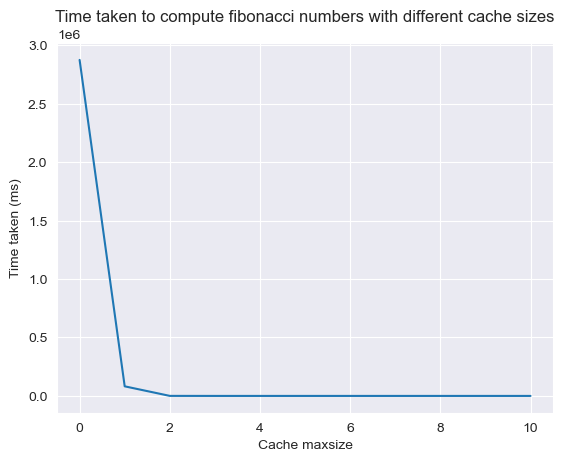

In [64]:
plt.plot(maxsize_values, execution_times)
plt.title("Time taken to compute fibonacci numbers with different cache sizes")
plt.xlabel("Cache maxsize")
plt.ylabel("Time taken (ms)")

### `@cached_property`:

Applied on class methods. Computed once and then stored for the life of the instance. Useful for expensive operations. Works only for methods that do not take any arguments since they are `properties`.

When we think about properties, the first thing that comes to my mind is the area of shapes. The area of a circle is a property for instance, since it doesn't change given a certain radius.

In [65]:
class Circle:
    def __init__(self, radius):
        self.radius = radius

    @cached_property
    def area(self):
        return np.pi* self.radius**2
    
    @cached_property
    def circumference(self):
        return 2 * np.pi * self.radius

In [66]:
circle = Circle(3)
print(circle.area)
print(circle.circumference)

28.274333882308138
18.84955592153876


Since we defined the area and circumference to be cached properties, we can also access them like so:

In [67]:
print(circle.area)
print(circle.circumference)

28.274333882308138
18.84955592153876


This is different from declaring them as a normal property decorator, which does not allow writes unless you write a corresponding setter method.
Furthermore, we can also assign values to these properties, i.e. they allow writes. 

In [68]:
print(circle.area, circle.circumference)
circle.area = 1
circle.circumference = 2
print(circle.area, circle.circumference)

28.274333882308138 18.84955592153876
1 2


Note that the cached property is not a callable, i.e the following code will error out:

In [69]:
try:
    circle.area()
except TypeError as e:
    print("Another error, how annoying...")
    print(f"Error message: {e}")

Another error, how annoying...
Error message: 'int' object is not callable


In [70]:
class Data:
    def __init__(self, input):
        self.data = np.array(input)

    @cached_property
    def mean(self):
        return np.mean(self.data)
    
    @cached_property
    def variance(self):
        return np.var(self.data)
    
    @cached_property
    def standard_deviation(self):
        return np.std(self.data)

#### A database example:

In [71]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# creating some fake data to simulate a large DB
df["noisy"] = False
dfs = [df]
for i in range(1, 401):
    new_df = df.copy()
    for col in new_df.columns[:-1]: #everything except the target
        noise = np.random.normal(0, 0.01*new_df[col].std(), new_df[col].shape)
        new_df[col] += noise
    dfs.append(new_df)
big_df = pd.concat(dfs, axis=0)
print(df.shape, big_df.shape)

(569, 32) (228169, 32)


In [72]:
%%time
connection = sqlite3.connect("breast_cancer.db")
big_df.to_sql("breast_cancer", connection, if_exists="replace", index_label="index")
connection.close()

CPU times: total: 2.8 s
Wall time: 6.67 s


In [73]:
%%time
conn = sqlite3.connect('breast_cancer.db')
df_loaded = pd.read_sql('SELECT * FROM breast_cancer', conn)
conn.close()
df_loaded.head()

CPU times: total: 2.2 s
Wall time: 3.08 s


,index,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,noisy
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0,0
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0,0
2,2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0,0
3,3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0,0
4,4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0,0


Now we observe that with the extra values that we added to the df, the database creation and the database load operations are beginning to hurt. The creation took around 5s and the load 3s. If we keep querying this database, hundreds of times, those times are going to add up. Hence it makes sense to cache the load / read operation of the DB. Despite the DB being "large" in this case, it isn't so large as to prohibit being loaded into memory, so we are still fortunate in that sense.

In [74]:
class Database:
    def __init__(self, db_path):
        self.connection = sqlite3.connect(db_path)

    @cached_property
    def load(self): # time-consuming operation
        query = "SELECT * FROM breast_cancer"
        df_from_db = pd.read_sql(query, self.connection)
        return df_from_db
    
    def exit(self):
        self.connection.close()

In [75]:
db_obj = Database("breast_cancer.db")
df = db_obj.load # loads db and caches the result

Using the `@cached_property` approach will help us save a lot of time!

With that, we've successfully added some functools knowledge to our python toolbox! 

References:
- https://docs.python.org/3/library/functools.html
- https://stackoverflow.com/questions/70301475/difference-between-functools-cache-and-lru-cache
- https://researchdatapod.com/python-typeerror-unhashable-type-list/
- https://realpython.com/python-reduce-function/ 